In [1]:
import getopt
import random
import sys
import time
from collections import deque
# make sure the root path is in system path
from pathlib import Path

from flatland.envs.malfunction_generators import malfunction_from_params
# base_dir = Path(__file__).resolve().parent.parent
# sys.path.append(str(base_dir))

import matplotlib.pyplot as plt
import numpy as np
import torch
from double_duelling_dqn import Agent
from observation_utils import normalize_observation

from flatland.envs.rail_generators import complex_rail_generator, rail_from_manual_specifications_generator, random_rail_generator , sparse_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator, sparse_schedule_generator
from flatland.envs.rail_env import RailEnv
from flatland.utils.rendertools import RenderTool
from flatland.envs.observations import TreeObsForRailEnv,GlobalObsForRailEnv,LocalObsForRailEnv
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.utils.ordered_set import OrderedSet
from flatland.core.grid.grid4_utils import get_new_position
from flatland.envs.agent_utils import RailAgentStatus


cpu


In [2]:
%matplotlib notebook
plt.ion()

In [3]:
Global_observations = GlobalObsForRailEnv()
Tree_observations = TreeObsForRailEnv(max_depth=2 , predictor=ShortestPathPredictorForRailEnv(30))

In [4]:
def environment1 ():
    transition_probability = [1.0,  # empty cell - Case 0
                          1.0,  # Case 1 - straight
                          1.0,  # Case 2 - simple switch
                          0.3,  # Case 3 - diamond drossing
                          0.5,  # Case 4 - single slip
                          0.5,  # Case 5 - double slip
                          0.2,  # Case 6 - symmetrical
                          0.0,  # Case 7 - dead end
                          0.2,  # Case 8 - turn left
                          0.2,  # Case 9 - turn right
                          1.0]  # Case 10 - mirrored switch

    # Example generate a random rail
    env = RailEnv(width=10,
                  height=10,
                  rail_generator=random_rail_generator(
                            cell_type_relative_proportion=transition_probability
                            ),
                  number_of_agents=1,
                  obs_builder_object= Tree_observations )
    return env

In [5]:
def environment2 ():
     #fix the randomness
    random.seed(1)
    np.random.seed(1)
    
    x_dim = 35
    y_dim = 35
    n_agents = 10

    stochastic_data = {'malfunction_rate': 8000,  # Rate of malfunction occurence of single agent
                       'min_duration': 15,  # Minimal duration of malfunction
                       'max_duration': 50  # Max duration of malfunction
                       }

    TreeObservation = TreeObsForRailEnv(max_depth=2)
    speed_ration_map = {1.: 0.25 ,  # Fast passenger train
                        1. / 2.: 0.25,  # Fast freight train
                        1. / 3.: 0.25,  # Slow commuter train
                        1. / 4.: 0.25}  # Slow freight train
    
    env = RailEnv(width=x_dim,
                  height=y_dim,
                  rail_generator=sparse_rail_generator(max_num_cities=3,
                                                       # Number of cities in map (where train stations are)
                                                       seed=1,  # Random seed
                                                       grid_mode=False,
                                                       max_rails_between_cities=2,
                                                       max_rails_in_city=3),
                  schedule_generator=sparse_schedule_generator(),
                  number_of_agents=n_agents,
                  malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
                  # Malfunction data generator
                  obs_builder_object=TreeObservation)

    return env

    

<IPython.core.display.Javascript object>


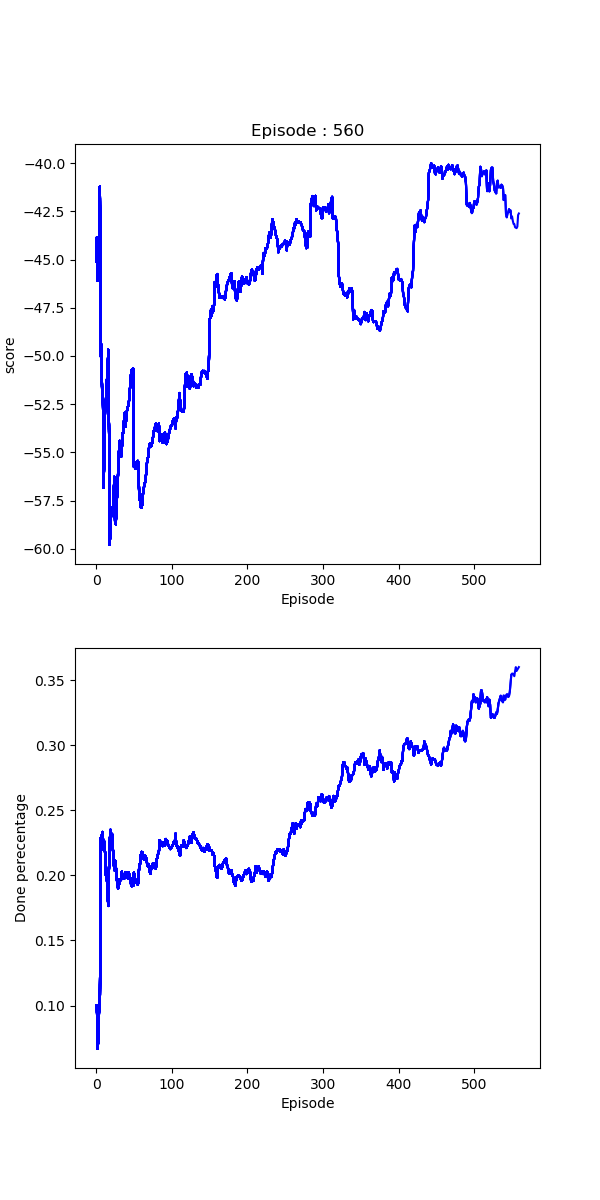

/home/arpit/anaconda3/envs/IA/lib/python3.7/site-packages/flatland/utils/rendertools.py:313: UserWarning: Predictor did not provide any predicted cells to render.                 Predictors builder needs to populate: env.dev_pred_dict
  Predictors builder needs to populate: env.dev_pred_dict")


Training 10 Agents on (35,35).	 Episode 566	 Average Score: -42.862	Dones: 36.60%	Epsilon: 0.32 	 Action Probabilities: 	 [0.15586617 0.21969825 0.21630785 0.23189215 0.17623557] 

In [ ]:
#For plotting
fig , axes= plt.subplots (2, 1 , figsize = (6 , 12))
fig.show()
fig.canvas.draw()

n_trials = 2000
    
env = environment2()
env_renderer = RenderTool(env, gl="PILSVG", )
obs , info = env.reset()
env_renderer.render_env(show=True , frames = True , show_observations = True , show_predictions=True )


#computing the size of the state space
# Given the depth of the tree observation and the number of features per node we get the following state_size
num_features_per_node = env.obs_builder.observation_dim
tree_depth = 2
nr_nodes = 0
for i in range(tree_depth + 1):
    nr_nodes += np.power(4, i)
state_size = num_features_per_node * nr_nodes

# The action space of flatland is 5 discrete actions
action_size = 5

# And the max number of steps we want to take per episode
max_steps = int(4 * 2 * (20 + env.height + env.width))

# Define training parameters
eps = 1.0
eps_end = 0.1
eps_decay = 0.998

action_dict = {}
scores_window = deque(maxlen=100)
done_window = deque(maxlen=100)
action_prob = [0] * action_size
agent_current_obs = [None] * env.get_num_agents()
agent_next_obs = [None] * env.get_num_agents()

done_list = []
scores_list = []
update_values = [False] * env.get_num_agents()
action_prob = [0] * action_size

agent = Agent(state_size , action_size)


#save the previous 
# agent.load ("Nets/checkpoint_env1_multi")

for trials in range(1 , n_trials + 1):
    
    #reset the environment
    obs , info = env.reset(True , True)
    env_renderer.reset()
    
    #Build the observations
    for a in range(env.get_num_agents()):
        if obs[a]:
            agent_current_obs[a] = normalize_observation(obs[a] , tree_depth , observation_radius = 10)
        else:
            agent_current_obs[a] = None

    #reset score and done
    score = 0
    env_done = 0
    cumulative_reward = 0

    #run the episode
    for step in range(max_steps):
        
        #choose the action for the current state
        for a in range(env.get_num_agents()):
            if (info['action_required'][a]):
                update_values[a] = True
                action = agent.act(agent_current_obs[a] , eps = eps)
                action_prob[action] += 1
            else:
                update_values[a] = False
                action = 0
                
            action_dict.update({a : action})
            
        #take the step in the environment
        next_obs , all_rewards , done , info = env.step(action_dict)
        env_renderer.render_env(show=True , frames = True , show_observations = True , show_predictions=True )
        
        for a in range(env.get_num_agents()):
            if next_obs[a]:
                agent_next_obs[a] = normalize_observation (next_obs[a] , tree_depth , observation_radius=10)
                
        #update replay buffer and train agent
        for a in range(env.get_num_agents()):
            if update_values[a]:
                agent.step(agent_current_obs[a] , action_dict[a] , all_rewards[a] ,
                           agent_next_obs[a] , done[a])
                agent_current_obs[a] = agent_next_obs[a]
                cumulative_reward += all_rewards[a]

#         dones_list.append(total_done/env.get_num_agents())
#         scores_list.append(cumulative_reward/env.get_num_agents())
        if done['__all__']:
            env_done = 1
            break
            
    eps = max(eps_end , eps * eps_decay)

    tasks_finished = 0
    for current_agent in env.agents:
        if current_agent.status == RailAgentStatus.DONE_REMOVED:
            tasks_finished += 1
    
    done_window.append(tasks_finished/env.get_num_agents())
    scores_window.append(cumulative_reward/env.get_num_agents())
    done_list.append(np.mean(done_window))
    scores_list.append(np.mean(scores_window))
    
    print(
            '\rTraining {} Agents on ({},{}).\t Episode {}\t Average Score: {:.3f}\tDones: {:.2f}%\tEpsilon: {:.2f} \t Action Probabilities: \t {}'.format(
                env.get_num_agents(), env.width, env.height,
                trials,
                np.mean(scores_window),
                100 * np.mean(done_window),
                eps, action_prob / np.sum(action_prob)), end=" ")

    if trials % 10 == 0:

        agent.save("Nets/checkpoint_env1_multi_city3")
        axes[0].set_title("Episode : {}".format(trials))
        axes[0].plot(scores_list , 'b')
        axes[0].set_xlabel("Episode")
        axes[0].set_ylabel("score")
        
        axes[1].plot(done_list , 'b')
        axes[1].set_xlabel("Episode")
        axes[1].set_ylabel("Done perecentage")
        fig.canvas.draw()

In [ ]:
# Todo
# 0. Do the training after modifying the reward function
# 1. Train single agent without regenerating the environment
# 2. Train multiple agent without regenerating the environment
# 3. Implement the same using convNet of the global observation for both single and multi agent
# 4. Design and discuss the shared Q-network for learning ad see the result
